#Generate customer clusters and generate marketing messages BigQuery DataFrames and GenAI

##Overview
Within the **BigQuery Studio** workspace, you can use a Colab Enterprise notebook interface and a workspace to save and share your notebooks. The notebooks come with **BigQuery DataFrames**, which provide a Pythonic DataFrame and ML API powered by the BigQuery engine. The operations happen in BigQuery at scale rather than within the notebook runtime.

*   [bigframes.pandas](https://cloud.google.com/python/docs/reference/bigframes/latest/bigframes.dataframe.DataFrame) provides a pandas-compatible API for analytics.
*   [bigframes.ml](https://cloud.google.com/python/docs/reference/bigframes/latest/bigframes.ml.cluster) provides a scikit-learn-like API for ML.
*   [bigframes.ml.llm](https://cloud.google.com/python/docs/reference/bigframes/latest/bigframes.ml.llm) provides LLM capabilities.

BigQuery DataFrames is an open-source Python package. It is pre-installed on  BigQuery Studio Python notebooks.  Additionally, you can always run `pip install --upgrade bigframes` to install the latest version.



## Objectives
This example illustrates a common Data to AI journey from data exploration to constructing a k-means machine learning model with BigFrames to segment customers of similar behaviors and demographics. Subsequently, Generative AI is applied to leverage cluster information and customer messaging to activate marketing campaigns. In doing so, you can build a data-centric, personalized marketing campaign all from BigQuery!

In this tutorial, you will:

* Generate features using BigQuery DataFrames
* Perform basic data exploration
* Implement a k-means clustering model with BigFrames
* Produce cluster descriptive statistics
* Utilize Generative AI to articulate ML model outputs in natural language for business users
* (Bonus) Use Generative AI to craft engaging emails tailored to customer segments.




###Helpful Links

* [BigFrames API Reference](https://cloud.google.com/python/docs/reference/bigframes/latest)


* [BigFrames GitHub page with sample notebooks](https://github.com/googleapis/python-bigquery-dataframes)

* [Troubleshooting notebook runtimes](https://cloud.google.com/colab/docs/troubleshooting)


## Before you Begin : Setup Steps


## Instal the `bigframes` package.

In [1]:
!pip install --upgrade bigframes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 392.1/392.1 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.2 MB/s eta 0:00:00
  Attempting uninstall: bigframes
    Found existing installation: bigframes 0.13.0
    Uninstalling bigframes-0.13.0:
      Successfully uninstalled bigframes-0.13.0


## Define notebook variables

Please update variables like your GCP Project ID (`PROJECT_ID`), dataset name (`DATASET_NAME`), and location (`LOCATION`).

The variables `DATASET_NAME`, `LOCATION` and `MODEL_NAME` are pre-populated, but you can update them if you wish.

Ensure that the dataset exists in the same GCP Project as `PROJECT_ID`.

In [2]:
#@title Setup Project Variables { run: "auto", display-mode: "form" }
PROJECT_ID = "\u003C>" #@param {type:"string"}
DATASET_NAME = "theLook_retail" #@param {type:"string"}
MODEL_NAME = "bqdf_customer_segment_cluster" #@param {type:"string"}
EVAL_NAME = MODEL_NAME + "_eval"
LOCATION = "US"  # @param {type:"string"}



---



## Step 1 : Basic Exploratory Data Analysis
To kick things off, let's first inspect our data prior to constructing any models. Within this tutorial, we'll be working with the [theLook eCommerce public dataset](https://console.cloud.google.com/marketplace/product/bigquery-public-data/thelook-ecommerce).

TheLook is an imaginary eCommerce apparel website. Within this dataset, you'll discover details about customers, products, orders, logistics, web events, and digital marketing campaigns. Our main emphasis is the `order_items` table, which contains transactional insights about customers. It's important to note that the contents of this dataset are artificially generated and are made available to professionals in the industry for the purposes of product exploration, testing, and assessment.

There are a few ways we can query data and get it into a dataframe. Here are two approaches:

#### **Initializing BigQuery Dataframes**

Import bigframes.pandas for a pandas-like interface. Use the Python SDK to bring data into a dataframe.

In [3]:
import bigframes as bf
import bigframes.pandas as bpd

BigQuery DataFrames uses a BigQuery session internally to manage metadata on the service side. This session is tied to a location . BigQuery DataFrames uses the US multi-region as the default location, but you can use session_options.location to set a different location. Every query in a session is executed in the location where the session was created.

In [4]:
bf.options.bigquery.project = PROJECT_ID
bf.options.bigquery.location = LOCATION

If you want to reset the location of the created DataFrame or Series objects, reset the session by executing `bf.close_session()`. After that, you can reuse `bf.options.bigquery.location` to specify another lo

 #### **`read_gbq` function**
 The `read_gbq` method accepts either a fully-qualified table ID or a SQL query.

In [5]:
df = bpd.read_gbq("bigquery-public-data.thelook_ecommerce.order_items")
df

,id,order_id,user_id,product_id,inventory_item_id,status,created_at,shipped_at,delivered_at,returned_at,sale_price
0,129723,89258,71199,28693,350752,Complete,2022-09-14 22:05:24+00:00,2022-09-14 06:23:00+00:00,2022-09-18 05:12:00+00:00,<NA>,19.200001
1,157467,108375,86438,10085,425687,Processing,2022-10-02 14:18:57+00:00,<NA>,<NA>,<NA>,140.0
2,174653,120236,95953,9568,472185,Complete,2023-11-02 05:20:49+00:00,2023-10-31 17:19:00+00:00,2023-11-02 18:22:00+00:00,<NA>,39.990002
3,25556,17558,13937,24926,69192,Cancelled,2023-08-18 06:55:09+00:00,<NA>,<NA>,<NA>,9.97
4,30478,20981,16650,22191,82449,Shipped,2023-11-06 04:01:56+00:00,2023-11-04 19:44:00+00:00,<NA>,<NA>,39.990002
5,62091,42554,33834,8397,167998,Processing,2020-01-03 15:46:40+00:00,<NA>,<NA>,<NA>,105.559998
6,86870,59667,47542,25253,234950,Shipped,2022-10-08 11:40:43+00:00,2022-10-06 17:16:00+00:00,<NA>,<NA>,22.950001
7,114640,78814,62789,27343,309924,Complete,2023-12-03 09:22:10+00:00,2023-12-06 08:36:00+00:00,2023-12-06 13:20:00+00:00,<NA>,49.950001
8,95558,65706,52350,28348,258410,Complete,2021-08-18 21:57:45+00:00,2021-08-20 11:57:00+00:00,2021-08-21 21:08:00+00:00,<NA>,19.99
9,148147,101915,81359,1970,400454,Returned,2023-02-02 17:09:59+00:00,2023-02-02 18:26:00+00:00,2023-02-03 04:56:00+00:00,2023-02-05 20:18:00+00:00,79.949997


#### **Restricting Dataframe columns**
Next, Choosing a restricted set of features for the purpose of conducting feature engineering.

In [6]:
df = df[["user_id", "order_id", "sale_price", "created_at", "status"]].rename(columns={"created_at": "order_created_date"})
df

,user_id,order_id,sale_price,order_created_date,status
0,71199,89258,19.200001,2022-09-14 22:05:24+00:00,Complete
1,86438,108375,140.0,2022-10-02 14:18:57+00:00,Processing
2,95953,120236,39.990002,2023-11-02 05:20:49+00:00,Complete
3,13937,17558,9.97,2023-08-18 06:55:09+00:00,Cancelled
4,16650,20981,39.990002,2023-11-06 04:01:56+00:00,Shipped
5,33834,42554,105.559998,2020-01-03 15:46:40+00:00,Processing
6,47542,59667,22.950001,2022-10-08 11:40:43+00:00,Shipped
7,62789,78814,49.950001,2023-12-03 09:22:10+00:00,Complete
8,52350,65706,19.99,2021-08-18 21:57:45+00:00,Complete
9,81359,101915,79.949997,2023-02-02 17:09:59+00:00,Returned


#### **Restricting the dataset to data spanning one year**

In [7]:
df = df[df["order_created_date"] > "2022-01-01"]
df = df[df["order_created_date"] < "2023-01-01"]
df

,user_id,order_id,sale_price,order_created_date,status
0,71199,89258,19.200001,2022-09-14 22:05:24+00:00,Complete
1,86438,108375,140.0,2022-10-02 14:18:57+00:00,Processing
6,47542,59667,22.950001,2022-10-08 11:40:43+00:00,Shipped
11,17974,22682,13.0,2022-06-09 13:48:45+00:00,Shipped
13,25057,31665,60.0,2022-06-04 02:40:21+00:00,Complete
21,23110,29137,69.0,2022-07-18 06:32:57+00:00,Complete
22,78469,98308,25.0,2022-12-17 07:48:59+00:00,Cancelled
27,48714,61106,23.0,2022-10-04 23:42:38+00:00,Shipped
29,29746,37454,27.68,2022-10-07 01:59:44+00:00,Shipped
32,59441,74569,5.95,2022-10-21 10:08:45+00:00,Processing


## Step 2 : Feature Engineering using BigQuery Dataframes

## Create features for k-means model.

We intend to compute features such as the total number of orders per customer, average spending per customer, and the return ratio, calculated as the total number of returns divided by the number of orders.

#### **Calculating total number of orders per customer**

In [8]:
count_orders = df.groupby(["user_id"])["order_id"].count()
count_orders

user_id
1     1
4     2
9     4
11    7
12    1
18    3
19    4
22    4
28    1
29    1
34    2
35    2
37    1
44    1
46    1
48    2
51    2
55    1
59    2
61    1
72    4
75    3
76    2
79    1
82    2
Name: order_id, dtype: Int64

#### **Calculating average spend per customer**

In [9]:
average_spend = df.groupby(["user_id"])["sale_price"].mean()
average_spend

user_id
1          185.0
4      43.970001
9       111.4625
11     65.204285
12         17.99
18         64.81
19        26.435
22    174.497501
28    107.099998
29     55.380001
34         46.25
35        19.995
37          75.0
44         23.16
46         16.99
48     30.495001
51        73.495
55          28.0
59         25.95
61           9.5
72       40.9875
75     53.976666
76     62.474998
79     48.200001
82         103.0
Name: sale_price, dtype: Float64

#### **Calculating total number of returned orders per customer**

In [10]:
df["returned"] = df["status"] == "Returned"
returned = df.groupby(["user_id"])["returned"].sum()
returned

user_id
1     0
4     0
9     0
11    0
12    0
18    0
19    0
22    0
28    0
29    0
34    0
35    0
37    0
44    0
46    1
48    0
51    0
55    0
59    0
61    0
72    0
75    0
76    0
79    0
82    0
Name: returned, dtype: Int64

#### **Calculating return ratio per customer**

In [11]:
return_ratio = returned / count_orders
return_ratio

user_id
1     0.0
4     0.0
9     0.0
11    0.0
12    0.0
18    0.0
19    0.0
22    0.0
28    0.0
29    0.0
34    0.0
35    0.0
37    0.0
44    0.0
46    1.0
48    0.0
51    0.0
55    0.0
59    0.0
61    0.0
72    0.0
75    0.0
76    0.0
79    0.0
82    0.0
dtype: Float64

#### **Compiling a conclusive dataframe for the development of a machine learning model for customer segmentation.**

In [12]:
df_customer = count_orders.rename("count_orders").to_frame()
df_customer["average_spend"] = average_spend
df_customer["return_ratio"] = return_ratio
df_customer

,count_orders,average_spend,return_ratio
user_id,,,
1,1,185.0,0.0
4,2,43.970001,0.0
9,4,111.4625,0.0
11,7,65.204285,0.0
12,1,17.99,0.0
18,3,64.81,0.0
19,4,26.435,0.0
22,4,174.497501,0.0
28,1,107.099998,0.0


## Step 3 : Create a k-means model to cluster ecommerce data

**K-means** is a widely used clustering algorithm that can dentify distinct groups or clusters within a dataset. With eCommerce data, k-means can segment customers, products, or transactions into meaningful groups for various analytical and business purposes.


#### **Cluster the customer data using BigFrames!**

In [13]:
from bigframes.ml.cluster import KMeans
from bigframes.ml.model_selection import train_test_split

# Split test and training data
df_customer = df_customer.dropna()
train_X, test_X = train_test_split(df_customer, test_size = 0.2)
# train_X = train_X.drop(columns = ["user_id"])
# Create a K-Means cluster model
kmeans = KMeans(n_clusters = 5)
kmeans.fit(train_X)


KMeans(n_clusters=5)

#### **Save the model to BigQuery**

In [14]:

kmeans.to_gbq(f"{PROJECT_ID}.{DATASET_NAME}.{MODEL_NAME}", True)

KMeans(n_clusters=5)

#### **Visualize the clusters**

Next we'll visualize the k-means clusters on a scatterplot. We'll chart `days_since_last_order` by `average_spend` and color by segment/cluster_id generated from the model.

In [16]:
#########################
#Plot K-Means clusters
#########################
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Import K-Means predictions to dataframe
# segments_df = kmeans.predict(df_customer).join(df_customer)
segments_df = kmeans.predict(df_customer)
segments_df = segments_df.rename(columns={'CENTROID_ID': 'segment_id'})
segments_pd = segments_df.sample(frac=0.2, random_state=1).to_pandas()

segments_pd


,segment_id,NEAREST_CENTROIDS_DISTANCE,count_orders,average_spend,return_ratio
user_id,,,,,
75,5,"[{'CENTROID_ID': 5, 'DISTANCE': 0.384329294010...",3,53.976666,0.0
82628,4,"[{'CENTROID_ID': 4, 'DISTANCE': 0.647686400318...",1,79.949997,0.0
66197,3,"[{'CENTROID_ID': 3, 'DISTANCE': 0.582539425649...",1,49.950001,1.0
64371,4,"[{'CENTROID_ID': 4, 'DISTANCE': 0.303629927776...",1,32.990002,0.0
71786,4,"[{'CENTROID_ID': 4, 'DISTANCE': 0.312954651655...",1,55.0,0.0
...,...,...,...,...,...
51751,4,"[{'CENTROID_ID': 4, 'DISTANCE': 0.682133332703...",2,58.200001,0.0
88466,2,"[{'CENTROID_ID': 2, 'DISTANCE': 0.674741762318...",5,50.624,0.0
46826,4,"[{'CENTROID_ID': 4, 'DISTANCE': 0.760199330296...",2,68.700001,0.0


#### **Generate scatterplot to display clusters**

Text(0.5, 1.0, 'Attribute Grouped by K-means Cluster')

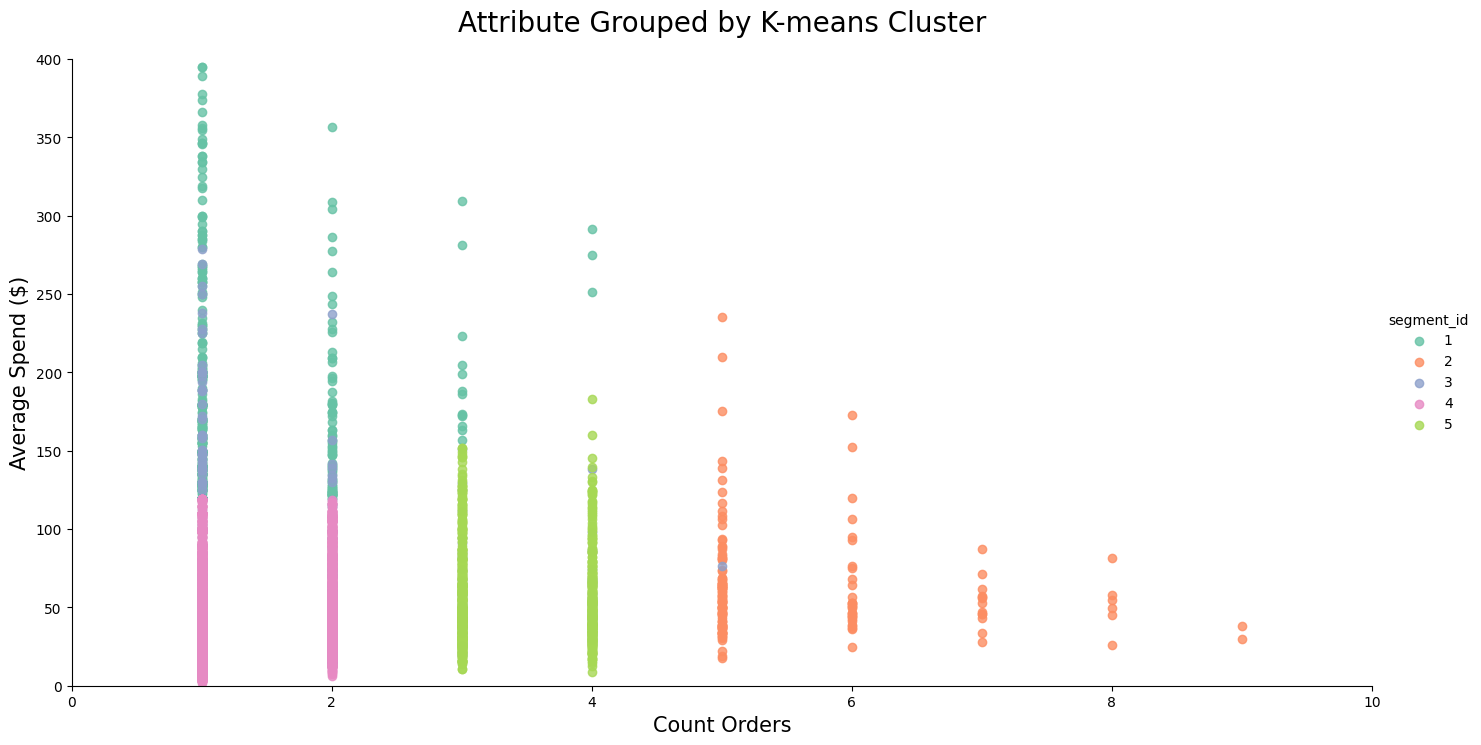

In [17]:
g = sns.lmplot(x='count_orders', y='average_spend', data=segments_pd, fit_reg=False, hue='segment_id', palette='Set2', height=7, aspect=2)
g = (g.set_axis_labels('Count Orders','Average Spend ($)', fontsize=15).set(xlim=(0,10),ylim=(0,400)))
plt.title('Attribute Grouped by K-means Cluster', pad=20, fontsize=20)

#### **Cluster Summary Statistics**

The visualization helped us see distinct clusters. Now let's generate some summary statistics around order recency, frequency, and spend by cluster.

In [18]:
df_centroid = kmeans.cluster_centers_
df_centroid

,centroid_id,feature,numerical_value,categorical_value
0,1,average_spend,194.408409,[]
1,1,count_orders,1.295263,[]
2,1,return_ratio,0.011316,[]
3,2,average_spend,59.674665,[]
4,2,count_orders,5.66388,[]
5,2,return_ratio,0.083164,[]
6,3,average_spend,58.330348,[]
7,3,count_orders,1.581578,[]
8,3,return_ratio,0.934142,[]
9,4,average_spend,43.509252,[]


In [19]:
df_centroid_pivot = df_centroid.pivot(index='centroid_id', columns='feature', values='numerical_value')
df_centroid_pivot

feature,average_spend,count_orders,return_ratio
centroid_id,,,
1,194.408409,1.295263,0.011316
2,59.674665,5.66388,0.083164
3,58.330348,1.581578,0.934142
4,43.509252,1.281373,0.0
5,56.648122,3.422423,0.020219


#### **Summary Statistics**
Whew! That's a lot of metrics and cluster info. How about we explain this to our colleagues using the magic of LLMs.

Let's begin by creating a string with the summary statistics from the last cell.

In [20]:
pd_df = df_centroid_pivot.reset_index().to_pandas()
pd_df.to_string(header=False, index=False)

cluster_info = []
for i, row in pd_df.iterrows():
  cluster_info.append("{0}, average spend ${2}, count of orders per person {1}, return ratio {3}"
    .format(row["centroid_id"], row["count_orders"], row["average_spend"], row["return_ratio"]) )

print(str.join("\n", cluster_info))

1, average spend $194.40840874661038, count of orders per person 1.295263157894745, return ratio 0.011315789473679977
2, average spend $59.67466521899343, count of orders per person 5.663879598662167, return ratio 0.08316411849020548
3, average spend $58.330347907537345, count of orders per person 1.5815776580107732, return ratio 0.9341417605748923
4, average spend $43.5092516940559, count of orders per person 1.2813732651571168, return ratio 1.3225531780847177e-14
5, average spend $56.648121649146184, count of orders per person 3.422422769871469, return ratio 0.020218674071497952


## Step 4 : Generative AI - Explain customer segments with Vertex AI PaLM API

To leverage Large Language Models directly from BigQuery, we will specify a [BigQuery connection](https://cloud.google.com/bigquery/docs/working-with-connections). If you already have a connection, you can simplify provide the name and skip the following creation steps

In [21]:
# Please fill in these values.
CONNECTION = "bq-llm"  # @param {type:"string"}

connection_name = f"{PROJECT_ID}.{LOCATION}.{CONNECTION}"

#### **BigQuery Connection Setup**
BigQuery lets you interact with services outside of BigQuery in Google Cloud services like Cloud Storage or Cloud Spanner, or in third-party sources like AWS or Azure. These external connections use the BigQuery Connection API.

In this case, we interact with Vertex AI Large Language models using Connection API.

In following cell, we try to use the provided connection, and if it doesn't exist, create a new one. We will also print the service account used.

Note : You may require additional permissions as [documented here ](https://cloud.google.com/bigquery/docs/working-with-connections#expandable-1)to peform following step.

In [23]:
from google.cloud import bigquery_connection_v1 as bq_connection
from bigframes.ml.llm import PaLM2TextGenerator
session = bpd.get_global_session()

In [24]:
# Initialize client and set request parameters
client = bq_connection.ConnectionServiceClient()
new_conn_parent = f"projects/{PROJECT_ID}/locations/{LOCATION}"
exists_conn_parent = f"projects/{PROJECT_ID}/locations/{LOCATION}/connections/{CONNECTION}"
cloud_resource_properties = bq_connection.CloudResourceProperties({})

# Try to connect using provided connection
try:
    request = client.get_connection(
        request=bq_connection.GetConnectionRequest(name=exists_conn_parent)
    )
    CONN_SERVICE_ACCOUNT = f"serviceAccount:{request.cloud_resource.service_account_id}"
# Create a new connection on error
except Exception:
    connection = bq_connection.types.Connection(
        {"friendly_name": CONNECTION, "cloud_resource": cloud_resource_properties}
    )
    request = bq_connection.CreateConnectionRequest(
        {
            "parent": new_conn_parent,
            "connection_id": CONNECTION,
            "connection": connection,
        }
    )
    response = client.create_connection(request)
    CONN_SERVICE_ACCOUNT = (
        f"serviceAccount:{response.cloud_resource.service_account_id}"
    )
# Set service account permissions
!gcloud projects add-iam-policy-binding {PROJECT_ID} --condition=None --no-user-output-enabled --member={CONN_SERVICE_ACCOUNT} --role='roles/bigquery.connectionUser'
!gcloud projects add-iam-policy-binding {PROJECT_ID} --condition=None --no-user-output-enabled --member={CONN_SERVICE_ACCOUNT} --role='roles/aiplatform.user'
!gcloud projects add-iam-policy-binding {PROJECT_ID} --condition=None --no-user-output-enabled --member={CONN_SERVICE_ACCOUNT} --role='roles/run.invoker'

print(CONN_SERVICE_ACCOUNT)

serviceAccount:bqcx-184378960328-5vzh@gcp-sa-bigquery-condel.iam.gserviceaccount.com


The resource connection service account requires certain project-level permissions:

`roles/aiplatform.user` and `roles/bigquery.connectionUser`: These roles are required for the connection to create a model definition using the LLM model in Vertex AI ( [documentation](https://cloud.google.com/bigquery/docs/generate-text#give_the_service_account_access)).
roles/run.invoker: This role is required for the connection to have read-only access to Cloud Run services that back custom/remote functions ([documentation](https://cloud.google.com/bigquery/docs/remote-functions#grant_permission_on_function)).

#### **Define the Large Language model using BigFrames**

Use bigframes.ml.llm to define the model and get BigFrames session


#### **Create a Prompt**
For each cluster, ask the LLM to act as a brand strategist and generate the following:
* Title
* Persona
* Next Marketing Step

In [25]:
model = PaLM2TextGenerator(session=session, connection_name=connection_name)

In [26]:


clusters = str.join("\n", cluster_info)

prompt = f"""
You're a creative brand strategist, given the following clusters, come up with \
creative brand persona, a catchy title, and next marketing action, \
explained step by step.

Clusters:
{clusters}

For each Cluster:
* Title:
* Persona:
* Next Marketing Step:
"""



#### **Prediction using Large Language model**

In [27]:
prompt_df = bpd.read_pandas(pd.DataFrame({'prompt': [prompt]}))
pred = model.predict(prompt_df, max_output_tokens=1024, temperature=0.55, top_p=0.8, top_k=40)
print(pred.iloc[0,0])

 **Cluster 1:**

* Title: The High-End Shoppers
* Persona: These customers are looking for the best of the best and are willing to pay a premium for it. They're typically affluent and have a high disposable income.
* Next Marketing Step: Target these customers with exclusive offers and discounts. Make them feel like they're getting something special that's not available to everyone else.

**Cluster 2:**

* Title: The Bargain Hunters
* Persona: These customers are always looking for a good deal and are willing to put in the time to find it. They're typically budget-minded and are always on the lookout for a sale.
* Next Marketing Step: Target these customers with discounts and promotions. Make it clear that they're getting a great deal on a quality product.

**Cluster 3:**

* Title: The Loyal Customers
* Persona: These customers are your bread and butter. They're the ones who keep coming back for more, even if they could find a cheaper product elsewhere. They're typically satisfied with

**Voila! We've now used k-Means clustering to create groups of spenders and explain their profiles.**

**Congratulations**! You have learned how to use **BigFrames** and manage each step of the process, including gathering data, data manipulation, and querying the LLM.



---



#### **BONUS #1: LLM Prompt Engineering**

Sometimes, though, you want a little bit extra.

#### **Personalized marketing emails**
Think about using Generative AI to also generate personalized marketing emails using witty e-mail headline for marketing campaign targeted to their clusters of customers

Reference: [Prompt Generation with Generative AI](https://cloud.google.com/blog/transform/prompt-debunking-five-generative-ai-misconceptions).

In [28]:


cluster_info = str.join('\n', cluster_info)

prompt = f"""
Pretend you're a creative strategist, analyse the following clusters and come up with \
creative brand persona for each that includes the detail of which Taylor Swift song is \
likely to be their favorite, a summary of how this relates to their purchasing behavior, \
and a witty e-mail headline for marketing campaign targeted to their group using \
their predicted favorite song title.

Clusters:
{cluster_info}


For each Cluster:
* Cluster:
* Interests:
* Favorite Taylor Swift Song:
* Witty email headline:
* Email body:

"""


In [29]:
prompt_df = bpd.read_pandas(pd.DataFrame({'prompt': [prompt]}))
pred = model.predict(prompt_df, max_output_tokens=1024, temperature=0.55, top_p=0.8, top_k=40)
print(pred.iloc[0,0])

 **Cluster 1**: 
* __Interests:__ 
High spenders who place few orders and rarely return items. 
* __Favorite Taylor Swift Song:__ 
"Shake It Off" 
* __Witty email headline:__ 
"You're a VIP, and we're shaking it off for you!" 
* __Email body:__ 
"Hey, VIP! 
We noticed you're a big spender who rarely returns items. We appreciate your loyalty, and we want to show you some love. 
That's why we're giving you early access to our latest sale. You'll get 20% off everything in our store, just for being you. 
So go ahead and treat yourself! We know you deserve it. 
Thanks for being a VIP! 
Love, 
The Taylor Swift Store" 


**Cluster 2**: 
* __Interests:__ 
Moderate spenders who place many orders and return items frequently. 
* __Favorite Taylor Swift Song:__ 
"We Are Never Ever Getting Back Together"
* __Witty email headline:__ 
"We're never ever getting back together with your old shopping habits!" 
* __Email body:__ 
"Hey, [customer name]! 
We noticed you're a frequent shopper who sometimes r

#### **BONUS #2: Generate Python in your Notebook**

If you have Duet AI enabled on your project, you can begin to generate Python directly within your Notebook:
* Open a new Code cell
* Click "Generate with AI"
* Paste one of the prompts below and hit Enter
* Generate Python code should appear in the cell


In [30]:
# prompt: 10 random numbers using numpy

In [31]:
# prompt: generate a bigframes dataframe from the table bigquery-public-data.thelook_ecommerce.order_items

In [32]:
# prompt: write some sql that queries the table bigquery-public-data.thelook_ecommerce.order_items.  Don't use python. Use %%bigquery.